Connected to .venv (Python 3.13.2)

 # Manual PyTorch Linear Regression for Wine Quality

 Implementing the core steps without the d2l library initially to understand the process.

In [19]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.stats import pearsonr # For correlation

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [20]:
# Load the dataset
# Assuming the file is named 'winequality.csv' and is in the same directory
try:
    df = pd.read_csv('./data/winequalityN.csv')
    print("Data loaded successfully.")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nInfo:")
    df.info()
except FileNotFoundError:
    print("Error: winequality.csv not found. Please make sure the file is in the correct directory.")
    # Create a dummy DataFrame if file not found, just to allow code structure to run
    # Replace this with your actual file path or ensure the file is present
    data_dummy = {
        'type': ['white', 'red', 'white', 'red'],
        'fixed acidity': [7.0, 6.2, 8.1, 5.9],
        'volatile acidity': [0.27, 0.60, 0.28, 0.65],
        'citric acid': [0.36, 0.08, 0.40, 0.12],
        'residual sugar': [20.7, 2.0, 6.9, 2.0],
        'chlorides': [0.045, 0.090, 0.050, 0.075],
        'free sulfur dioxide': [45.0, 32.0, 30.0, 32.0],
        'total sulfur dioxide': [170.0, 44.0, 97.0, 44.0],
        'density': [1.0010, 0.9949, 0.9951, 0.99547],
        'pH': [3.00, 3.45, 3.26, 3.57],
        'sulphates': [0.45, 0.58, 0.44, 0.71],
        'alcohol': [8.8, 10.5, 10.1, 10.2],
        'quality': [6, 5, 6, 5]
    }
    df = pd.DataFrame(data_dummy)
    print("\nUsing dummy data as winequality.csv was not found.")

Data loaded successfully.
Shape: (6497, 13)
Columns: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             649

 ### Handle Categorical Feature ('type')

In [21]:
# Convert 'type' column to dummy variables
# 'white' and 'red' will become boolean columns (0 or 1)
df = pd.get_dummies(df, columns=['type'], dtype=float) # Use dtype=float to ensure numeric

print("\nDataFrame after dummy encoding:")
print(df.head())
print("\nColumns after dummy encoding:", df.columns.tolist())


DataFrame after dummy encoding:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  type_red  type_white  
0      8.

 ### Handle Missing Values

In [22]:
print("\nMissing values per column before imputation:")
print(df.isnull().sum())

# Impute missing values using the mean of each column
# Mean is calculated *before* train/test split, which is a simple approach.
# A more robust approach would be to calculate mean only on training data.
# Let's stick to the simple approach for now as per homework suggestions.
df = df.fillna(df.mean())

print("\nMissing values per column after imputation:")
print(df.isnull().sum())

# Check if any NaNs remain (should be zero)
if df.isnull().sum().sum() > 0:
    print("Warning: NaNs still present after imputation!")


Missing values per column before imputation:
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
type_red                 0
type_white               0
dtype: int64

Missing values per column after imputation:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type_red                0
type_white              0
dtype: int64


 ### Separate Features (X) and Target (y)

In [23]:
X = df.drop('quality', axis=1)
y = df['quality']

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nFirst 5 rows of X (features):")
print(X.head())
print("\nFirst 5 values of y (target):")
print(y.head())


Shape of X: (6497, 13)
Shape of y: (6497,)

First 5 rows of X (features):
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol 

 ### Split Data into Training and Validation Sets

In [24]:
# Using sklearn's train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # Use random_state for reproducibility

print("\nShape of training features (X_train):", X_train.shape)
print("Shape of validation features (X_val):", X_val.shape)
print("Shape of training target (y_train):", y_train.shape)
print("Shape of validation target (y_val):", y_val.shape)


Shape of training features (X_train): (5197, 13)
Shape of validation features (X_val): (1300, 13)
Shape of training target (y_train): (5197,)
Shape of validation target (y_val): (1300,)


 ### Feature Scaling (Normalization)

In [25]:
# Use StandardScaler to normalize features.
# Fit on training data, transform both training and validation data.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) # Use the *same* scaler fitted on training data

print("\nShape of scaled training features:", X_train_scaled.shape)
print("Shape of scaled validation features:", X_val_scaled.shape)
print("\nMean of scaled X_train:", np.mean(X_train_scaled, axis=0)) # Should be close to 0
print("Std Dev of scaled X_train:", np.std(X_train_scaled, axis=0)) # Should be close to 1


Shape of scaled training features: (5197, 13)
Shape of scaled validation features: (1300, 13)

Mean of scaled X_train: [ 1.21340519e-16  8.98945254e-17  2.33794127e-16 -4.44345563e-18
  3.55476450e-17  6.15247703e-17  9.91232410e-17 -1.10830038e-14
 -1.37063516e-16 -5.00059661e-16 -4.79893208e-16 -1.23049541e-17
 -1.40823363e-16]
Std Dev of scaled X_train: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 ### Convert to PyTorch Tensors

In [26]:
# Convert NumPy arrays to PyTorch tensors
# Ensure dtype is float32 for inputs and targets for typical network layers/loss functions
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # .values to get numpy array, unsqueeze(1) adds a dimension for consistency with model output shape (batch_size, 1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

print("\nShape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_val_tensor:", X_val_tensor.shape)
print("Shape of y_val_tensor:", y_val_tensor.shape)


Shape of X_train_tensor: torch.Size([5197, 13])
Shape of y_train_tensor: torch.Size([5197, 1])
Shape of X_val_tensor: torch.Size([1300, 13])
Shape of y_val_tensor: torch.Size([1300, 1])


 ### Create DataLoaders

In [27]:
# Use standard PyTorch TensorDataset and DataLoader
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle training data

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Do not shuffle validation data

print("\nCreated DataLoaders.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Created DataLoaders.
Number of training batches: 163
Number of validation batches: 41


 ## 2. Model Definition

In [28]:
# Define the simple linear regression model using torch.nn.Module
class SimpleLinearRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # torch.nn.Linear automatically handles weights and bias
        self.linear = torch.nn.Linear(input_dim, 1)

        # Initialize weights and bias as suggested by the professor
        # Access .data to modify weights/bias directly without tracking gradients
        self.linear.weight.data.normal_(0, 0.01)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        return self.linear(x)

# Get the input dimension from the scaled training data
input_dim = X_train_tensor.shape[1]

# Instantiate the model
model = SimpleLinearRegression(input_dim)

print("\nModel created:")
print(model)


Model created:
SimpleLinearRegression(
  (linear): Linear(in_features=13, out_features=1, bias=True)
)


 ## 3. Loss Function and Optimizer

In [ ]:
# Mean Squared Error (MSE) loss for regression
loss_fn = torch.nn.MSELoss()

# Stochastic Gradient Descent (SGD) optimizer
# Pass model.parameters() to the optimizer
# The professor suggested a low learning rate (e.g., 10^-5) if divergence occurs without scaling.
# WITH scaling, we can usually use a higher learning rate. Let's start with a small one and try increasing it if performance is poor.
# A rate like 0.01 or even 0.1 might be appropriate after scaling. Let's try 0.01 first.
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"\nUsing MSELoss and SGD optimizer with learning rate = {learning_rate}")


Using MSELoss and SGD optimizer with learning rate = 0.01


 ## 4. Training Loop

In [ ]:
num_epochs = 200 # Start with a reasonable number of epochs

train_losses = []
val_losses = []

print("\nStarting training...")

for epoch in range(num_epochs):
    # Training phase
    model.train() # Set model to training mode
    total_train_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Calculate gradients
        optimizer.step()      # Update weights

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss: torch.Tensor = loss_fn(outputs, targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print progress
    if (epoch + 1) % 50 == 0: # Print every 10 epochs
        print(f'Epoch [{epoch+1:_}/{num_epochs:_}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Starting training...
Epoch [50/200], Train Loss: 0.5580, Val Loss: 0.4753
Epoch [100/200], Train Loss: 0.5563, Val Loss: 0.4779
Epoch [150/200], Train Loss: 0.5573, Val Loss: 0.4808
Epoch [200/200], Train Loss: 0.5558, Val Loss: 0.4817


 ### Plotting Loss

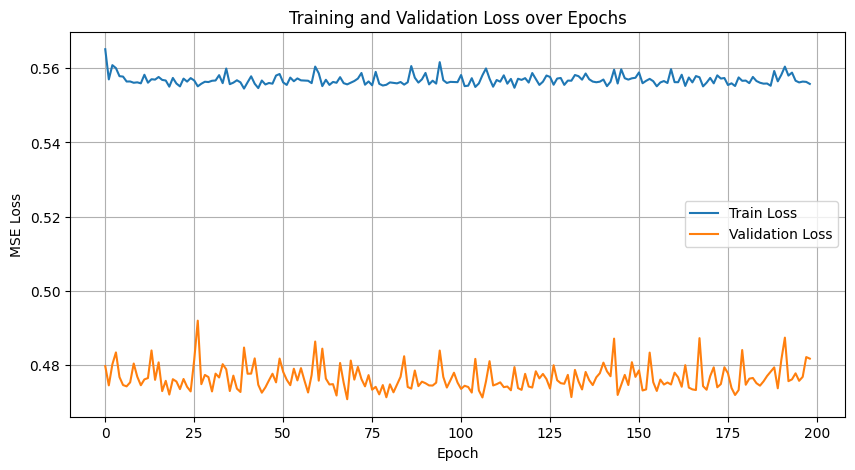

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

 ## 5. Evaluation

 Evaluate the model on the **validation set** using the required metrics.

In [32]:
# Set model to evaluation mode and disable gradients
model.eval()
with torch.no_grad():
    # Get predictions on the entire validation set
    val_predictions_tensor = model(X_val_tensor)

# Convert tensors to NumPy arrays for metric calculations
val_predictions = val_predictions_tensor.cpu().numpy()
y_val_np = y_val_tensor.cpu().numpy()

# Ensure predictions and targets have the same shape (batch_size, 1) or (batch_size,)
# y_val_np is (batch_size, 1) due to unsqueeze, val_predictions is (batch_size, 1)
# Let's flatten them for easier metric calculations
val_predictions = val_predictions.flatten()
y_val_np = y_val_np.flatten()

 ### Trivial Predictor (Mean)

In [33]:
# Calculate the mean quality from the TRAINING data
# The trivial predictor always predicts this mean value
y_train_mean = y_train.mean()
print(f"\nMean quality in training data (Trivial Predictor Value): {y_train_mean:.4f}")

# Trivial predictions for the validation set
trivial_predictions = np.full_like(y_val_np, y_train_mean)


Mean quality in training data (Trivial Predictor Value): 5.8178


 ### 5.1. Mean Absolute Error (MAE)

In [34]:
# Model MAE
model_mae = np.abs(y_val_np - val_predictions).mean()
print(f"Model Mean Absolute Error (MAE) on Validation Set: {model_mae:.4f}")

# Trivial Predictor MAE
trivial_mae = np.abs(y_val_np - trivial_predictions).mean()
print(f"Trivial Predictor MAE on Validation Set: {trivial_mae:.4f}")

# Compare
print(f"Model MAE vs Trivial MAE: {model_mae:.4f} vs {trivial_mae:.4f}")
if model_mae < trivial_mae:
    print("-> Model performs better than the trivial predictor (lower MAE).")
elif model_mae > trivial_mae:
     print("-> Model performs worse than the trivial predictor (higher MAE).")
else:
    print("-> Model performs similarly to the trivial predictor (equal MAE).")

Model Mean Absolute Error (MAE) on Validation Set: 0.5502
Trivial Predictor MAE on Validation Set: 0.6687
Model MAE vs Trivial MAE: 0.5502 vs 0.6687
-> Model performs better than the trivial predictor (lower MAE).


 ### 5.2. Classification by Rounding (Accuracy)

In [35]:
# Round predictions and actual values to the nearest integer (1-7)
# Note: quality is already integers, but predictions are floats. We round predictions.
# We also might want to clip predictions to the valid range [1, 7], though not strictly required by prompt.
# Let's round the actual quality values too, in case there were floating point issues,
# although the dataset description says they are integers 1-7.
rounded_predictions = np.round(val_predictions)
rounded_actual = np.round(y_val_np)

# Calculate accuracy: proportion of predictions that exactly match the rounded actual quality
# Check for values outside the 1-7 range (optional but good practice)
# print(f"Min/Max rounded predictions: {rounded_predictions.min()}/{rounded_predictions.max()}")
# print(f"Min/Max rounded actual: {rounded_actual.min()}/{rounded_actual.max()}")

# Clip to 1-7 range if desired (e.g., rounded_predictions = np.clip(rounded_predictions, 1, 7))
# For accuracy calculation based on exact match, clipping might change the result slightly.
# Let's calculate accuracy *before* clipping, as the comparison is against the rounded target.

model_accuracy = (rounded_predictions == rounded_actual).mean()
print(f"\nModel Accuracy (by rounding) on Validation Set: {model_accuracy:.4f}")

# Trivial Predictor Accuracy (by rounding)
# The trivial predictor always predicts y_train_mean. We round this mean and compare to rounded actuals.
rounded_trivial_prediction = np.round(y_train_mean)
trivial_accuracy = (rounded_trivial_prediction == rounded_actual).mean()
print(f"Trivial Predictor Accuracy (by rounding) on Validation Set: {trivial_accuracy:.4f}")

# Random Predictor Accuracy (just for comparison context)
# There are 7 classes (1-7). A random guess has a 1/7 probability of being correct.
random_accuracy = 1/7
print(f"Random Predictor Accuracy (1/7): {random_accuracy:.4f}")


# Compare
print(f"Model Accuracy vs Trivial Accuracy vs Random Accuracy: {model_accuracy:.4f} vs {trivial_accuracy:.4f} vs {random_accuracy:.4f}")
if model_accuracy > trivial_accuracy:
    print("-> Model performs better than the trivial predictor (higher accuracy).")
elif model_accuracy < trivial_accuracy:
     print("-> Model performs worse than the trivial predictor (lower accuracy).")
else:
    print("-> Model performs similarly to the trivial predictor (equal accuracy).")

if model_accuracy > random_accuracy:
     print("-> Model performs better than a random predictor.")
else:
     print("-> Model performs similarly to or worse than a random predictor.")


Model Accuracy (by rounding) on Validation Set: 0.5469
Trivial Predictor Accuracy (by rounding) on Validation Set: 0.4454
Random Predictor Accuracy (1/7): 0.1429
Model Accuracy vs Trivial Accuracy vs Random Accuracy: 0.5469 vs 0.4454 vs 0.1429
-> Model performs better than the trivial predictor (higher accuracy).
-> Model performs better than a random predictor.


 ### 5.3. Correlation

In [36]:
# Calculate Pearson correlation coefficient between predictions and actual values
# pearsonr returns (correlation_coefficient, p_value)
correlation, _ = pearsonr(y_val_np, val_predictions)
print(f"\nCorrelation between Model Predictions and Actual Quality: {correlation:.4f}")

# Correlation for Trivial and Random Predictors:
# A constant prediction (trivial) has zero correlation with the target variable (unless the target is also constant).
# Random predictions would also ideally have zero correlation with the target.
print("Trivial and Random predictors are expected to have correlation close to 0.")


Correlation between Model Predictions and Actual Quality: 0.5757
Trivial and Random predictors are expected to have correlation close to 0.
